## lFDTN Sandbox - Not using complex api

This notebook provides an overview of the steps necessary to build the *lFDTN Frame Prediction* algorithm and serves as a starting point to transition the underlying tensors to the torch complex api and reworked fft modules. Also, this notebook is supposed to be standalone in the sense that it doesn't require any other parts of the lFDTN module.

In [1]:
# import the required modules
import torch
import torch.fft
import torch.nn as nn
from torch.functional import F
import sys
import numpy as np

# print environment info
print("Python Version:", sys.version)
print("PyTorch Version:", torch.__version__)
print("Cuda Version:", torch.version.cuda)
print("CUDNN Version:", torch.backends.cudnn.version())
print('Numpy Version:', np.__version__)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is : {device}")

Python Version: 3.8.5 (default, Sep  4 2020, 07:30:14) 
[GCC 7.3.0]
PyTorch Version: 1.8.1
Cuda Version: 10.2
CUDNN Version: 7605
Numpy Version: 1.19.2
Device is : cuda


#### Overview

The algorithm we want to implement is described in pseudocode below. Note that it has several distinct steps, which are themselves tiny algorithms:

* LFT
* get_phase_differences
* $\mathcal{MM}$
* phase_add
* m_iLFT

We proceed to cover these one by one.

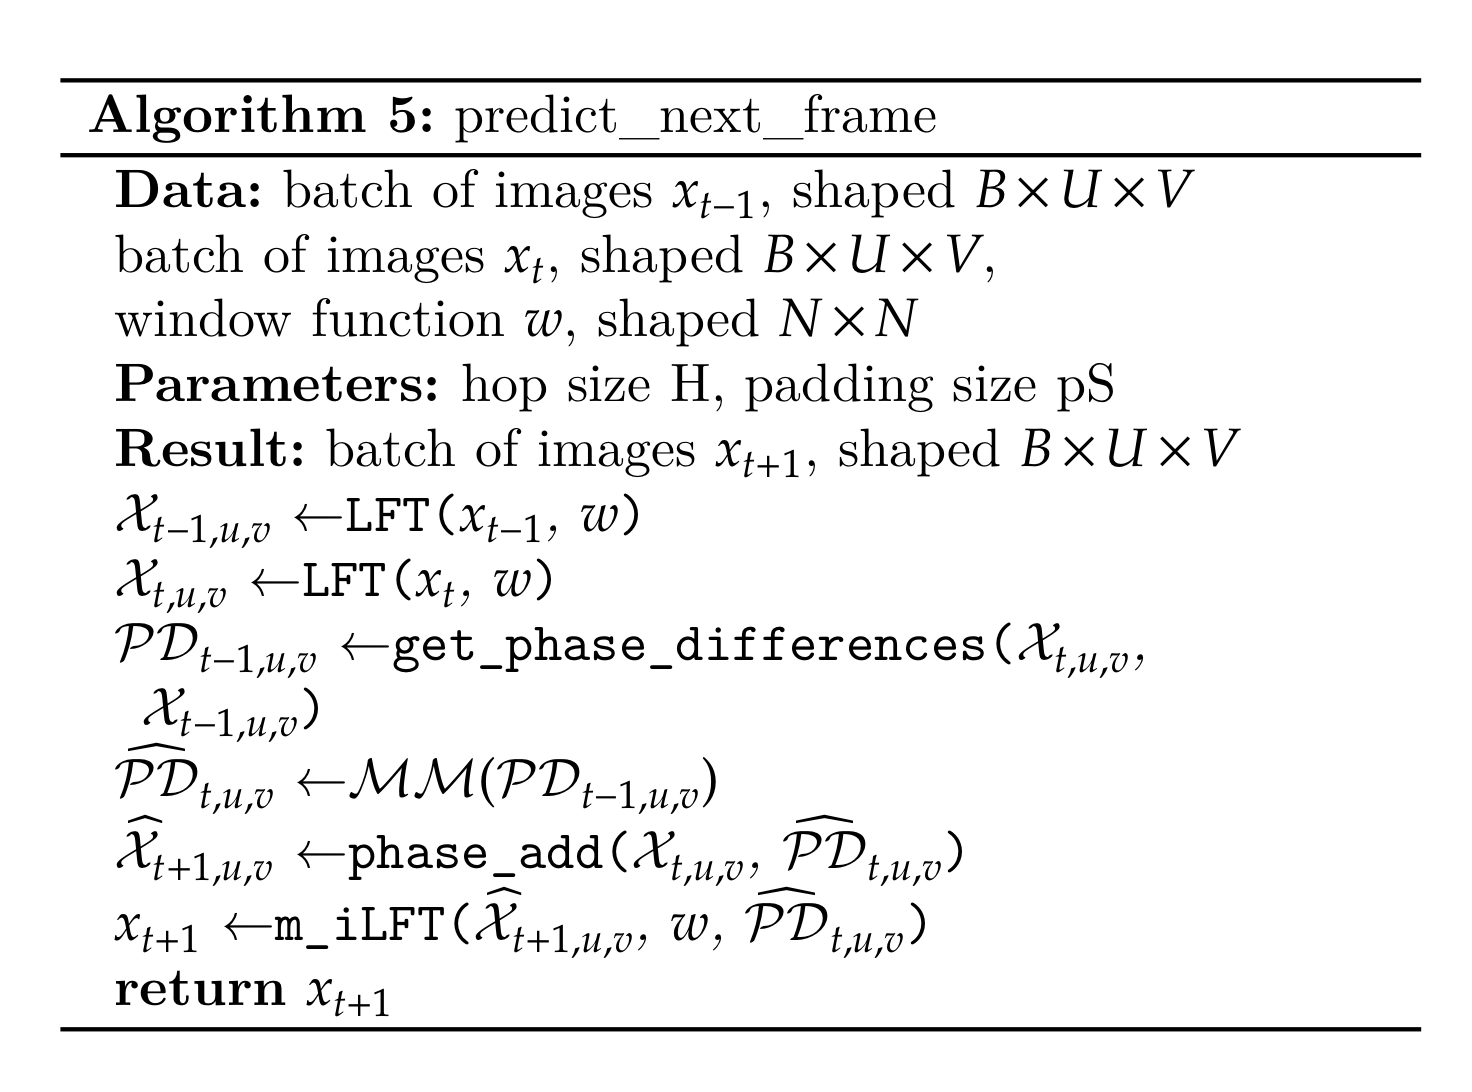

In [2]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='prototyping/predict_next_frame.jpg', width=600, height=450)

#### LFT

First we need to write the LFT, which covers the input image with overlapping cells arranged on a regular grid and then calculates the Fourier Transform of each cell individually. Please find the exact description in pseudocode below.

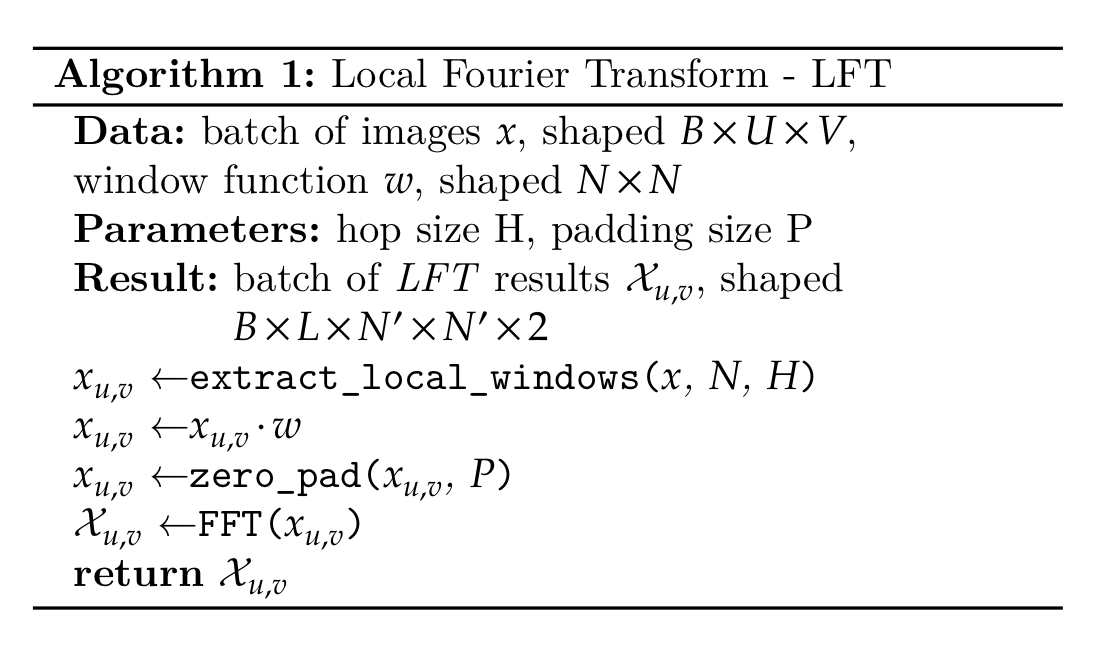

In [3]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='prototyping/LFT.jpg', width=600, height=450)

In [4]:
# local window extraction used in LFT
def extract_local_windows(batch, windowSize: int, y_stride: int = 1, x_stride: int = 1, padding: int = 0):
    BS,CS,HH,WW = batch.shape
    windowSizeAdjust = windowSize + 2 * padding
    padSize = int(x_stride * ((windowSizeAdjust - 1) // x_stride))
    fold_params = dict(kernel_size=(windowSizeAdjust, windowSizeAdjust), padding=(padSize, padSize),
                       stride=(y_stride, x_stride))
    result = nn.functional.unfold(batch, **fold_params)
    result = result.view(BS,CS,windowSizeAdjust*windowSizeAdjust,-1)
    result = result.permute(0,3,1,2)
    return result.reshape(BS, -1, windowSizeAdjust, windowSizeAdjust)


normalizeFFT = False
# locally define the fft to transition to complex api
def custom_fft(t_r):
    """2D FFT an input tensor

    Args:
        t_r -- tensor containing a real 2D signal in its last two dimensions
    """
    t_c = torch.stack([t_r, torch.zeros_like(t_r, requires_grad=False)], dim=-1)
    t_c = torch.view_as_complex(t_c)
    result = torch.fft.fftn(t_c, dim=(-2, -1), norm="forward" if normalizeFFT else "backward")
    return torch.view_as_real(result)


# we can use the previous two functions to define the LFT
def LFT(batch, window, y_stride: int = 1, x_stride: int = 1, padding: int = 1):
    windowBatch = extract_local_windows(batch, window.shape[0], y_stride=y_stride, x_stride=x_stride, padding=padding)
    windowPadded = F.pad(window, (padding, padding, padding, padding))
    localImageWindowsSmoothedPadded = windowBatch * windowPadded

    return custom_fft(localImageWindowsSmoothedPadded)

# wrap the LFT to accept WandB style config dicts as arguments
def compact_LFT(batch, window, config):
    return LFT(batch, window, x_stride=config.stride, y_stride=config.stride, padding=config.window_padding_constrained)

In [5]:
# Here we apply the LFT
# Create dummy input to LFT
B, C, H, W = 12, 1, 65, 65 # Batch size, Number of Color Channels, Frame Height, Frame Width
S, P  = 4, 4 # hopsize, padding
x_prev = torch.rand((B, C, H, W)).to(device) # Batch of previous frames at time t-1
x_curr = torch.rand((B, C, H, W)).to(device) # Batch of current frames at time t
N = 11 # Window Size
window = torch.ones((N,N)).to(device)

# This class is just a config dictionary
class wandbdummy_LFT():
    def __init__(self, stride, win_pad):
        self.stride = stride
        self.window_padding_constrained = win_pad
# create hyperparameters (H and pS in pseudocode)
LFT_config = wandbdummy_LFT(stride=S, win_pad=P)
# apply LFT to x_prev and x_curr
LFT_prev = compact_LFT(x_prev, window, LFT_config)
LFT_curr = compact_LFT(x_curr, window, LFT_config)
print(f'LFT output shape: {LFT_curr.shape}')

LFT output shape: torch.Size([12, 400, 19, 19, 2])


#### get_phase_difference

Next we need to calculate the local phase differences between x_curr and x_prev. These will point from x_prev to x_curr. This operation is element-wise for the LFT outputs.

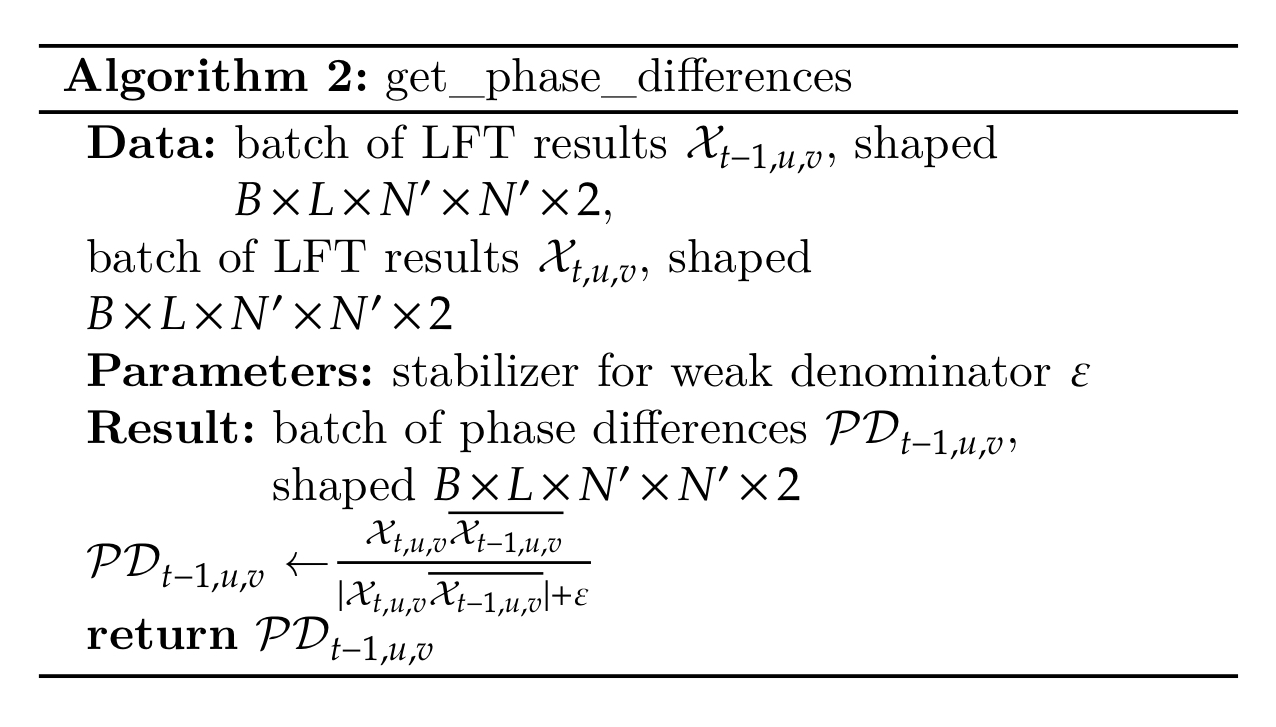

In [6]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='prototyping/get_phase_differences.jpg', width=600, height=450)

In [7]:
# We need complex conjugation, division, multiplication and absolute values for this
# The complex api is expected to simply this step alot
def complex_div(t1, t2, eps=1e-8):
    assert t1.size() == t2.size()
    assert t1.size()[-1] == 2
    assert t1.device == t2.device
    t1re = torch.index_select(t1, -1, torch.tensor([0], device=t1.device))
    t1im = torch.index_select(t1, -1, torch.tensor([1], device=t1.device))
    t2re = torch.index_select(t2, -1, torch.tensor([0], device=t1.device))
    t2im = torch.index_select(t2, -1, torch.tensor([1], device=t1.device))
    denominator = t2re ** 2 + t2im ** 2 + eps
    numeratorRe = t1re * t2re + t1im * t2im
    numeratorIm = t1im * t2re - t1re * t2im
    return torch.cat([numeratorRe / denominator, numeratorIm / denominator], -1)


def complex_mul(t1, t2):
    assert t1.size() == t2.size()
    assert t1.size()[-1] == 2
    assert t1.device == t2.device
    t1re = torch.index_select(t1, -1, torch.tensor([0], device=t1.device))
    t1im = torch.index_select(t1, -1, torch.tensor([1], device=t1.device))
    t2re = torch.index_select(t2, -1, torch.tensor([0], device=t1.device))
    t2im = torch.index_select(t2, -1, torch.tensor([1], device=t1.device))
    return torch.cat([t1re * t2re - t1im * t2im, t1re * t2im + t1im * t2re], -1)


def complex_conj(iT):
    assert iT.size()[-1] == 2
    iTre = torch.index_select(iT, -1, torch.tensor([0], device=iT.device))
    iTim = torch.index_select(iT, -1, torch.tensor([1], device=iT.device))
    return torch.cat([iTre, -iTim], -1)


def complex_abs(iT):
    assert iT.size()[-1] == 2
    iTre = torch.index_select(iT, -1, torch.tensor([0], device=iT.device))
    iTim = torch.index_select(iT, -1, torch.tensor([1], device=iT.device))
    outR = torch.sqrt(iTre ** 2 + iTim ** 2 + 1e-8)
    return torch.cat([outR, torch.zeros_like(outR)], -1)

# For prediction hf0 is the current frame and hf1 is the previous frame
def getPhaseDiff(hf0, hf1,energy = False):
    R = complex_mul(hf0, complex_conj(hf1))
    Energy = complex_abs(R)
    R = complex_div(R, Energy)
    if energy:
        return R,Energy[...,0:1]/(Energy.shape[-2]*Energy.shape[-3])
    return R,None

In [8]:
PD_prev, _ = getPhaseDiff(LFT_curr, LFT_prev)
print(f'Local Phase Differences shape: {PD_prev.shape}')

Local Phase Differences shape: torch.Size([12, 400, 19, 19, 2])


#### Transform Model MM

The transform model can regularize the phase differences as well as correct some artifacts. Also, it transports the encoded local transformations forward spatio-temporally. It is a learned model which we replace by a trivial dummy here.

In [9]:
class TransformModel(torch.nn.Module):
    def __init__(self):
        super(TransformModel, self).__init__()
        # transform each (N',N',2) phase diff two numbers
        # these encode local velocity
        self.bottleneck = lambda x: x
        # regularize, correct and transport the local velocities
        self.model = lambda x: x
        # reconstruct phase differences from refined local velocities
        self.phase_diff_builder = lambda x: x

    def forward(self, x):
        # shape at input: (B, L, N', N', 2)
        x = self.bottleneck(x)
        # shape after bottleneck: (B, L, 2)
        x = self.model(x)
        # shape after refinement: (B, L, 2)
        x = self.phase_diff_builder(x)
        # shape after reconstruction of phase diffs: (B, L, N', N', 2)
        return x

In [10]:
# create transform model
MM = TransformModel()
# transport and refine phase differences
PD_curr = MM(PD_prev)
print(f'Local Phase Differences after Refinement shape: {PD_curr.shape}')

Local Phase Differences after Refinement shape: torch.Size([12, 400, 19, 19, 2])


#### phase_add

Next we add the refined local phase differences to the LFT of the current frame, which produces what we understand as the LFT of the next frame. The operation is again element-wise, as described below.

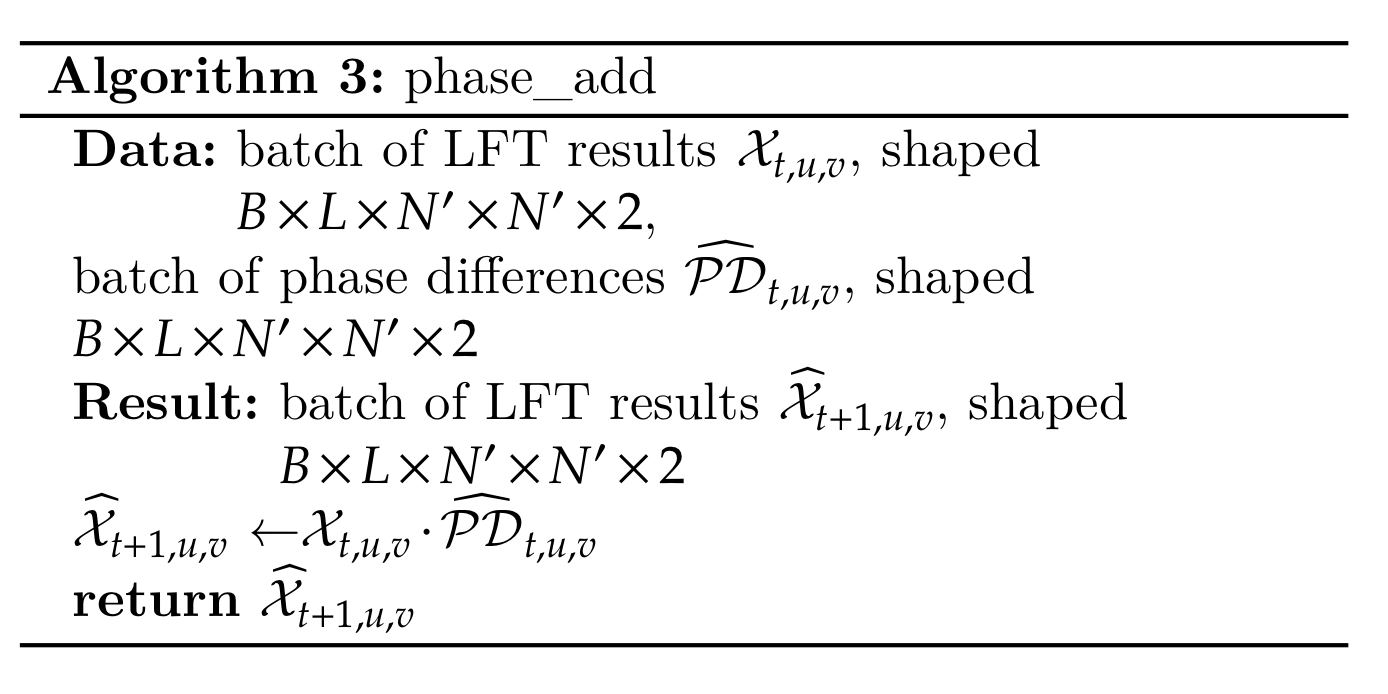

In [11]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='prototyping/phase_add.jpg', width=600, height=450)

In [12]:
# the multiplication is once again complex, which we have already defined in the context of the phase diffs above
def getPhaseAdd(hf0, T):
    return complex_mul(hf0, T)

In [13]:
LFT_next = getPhaseAdd(LFT_curr, PD_curr)
print(f'LFT of next frame shape: {LFT_next.shape}')

LFT of next frame shape: torch.Size([12, 400, 19, 19, 2])


#### m_iLFT

Finally we need to invert the LFT so that we can covert the LFT of the next frame into the next frame. Since we windowed the extracted local cells and would like this implementation to work for arbitrary window functions, we consider that these would need to be locally shifted as well for a proper reconstruction. The process is described in pseudocode below.

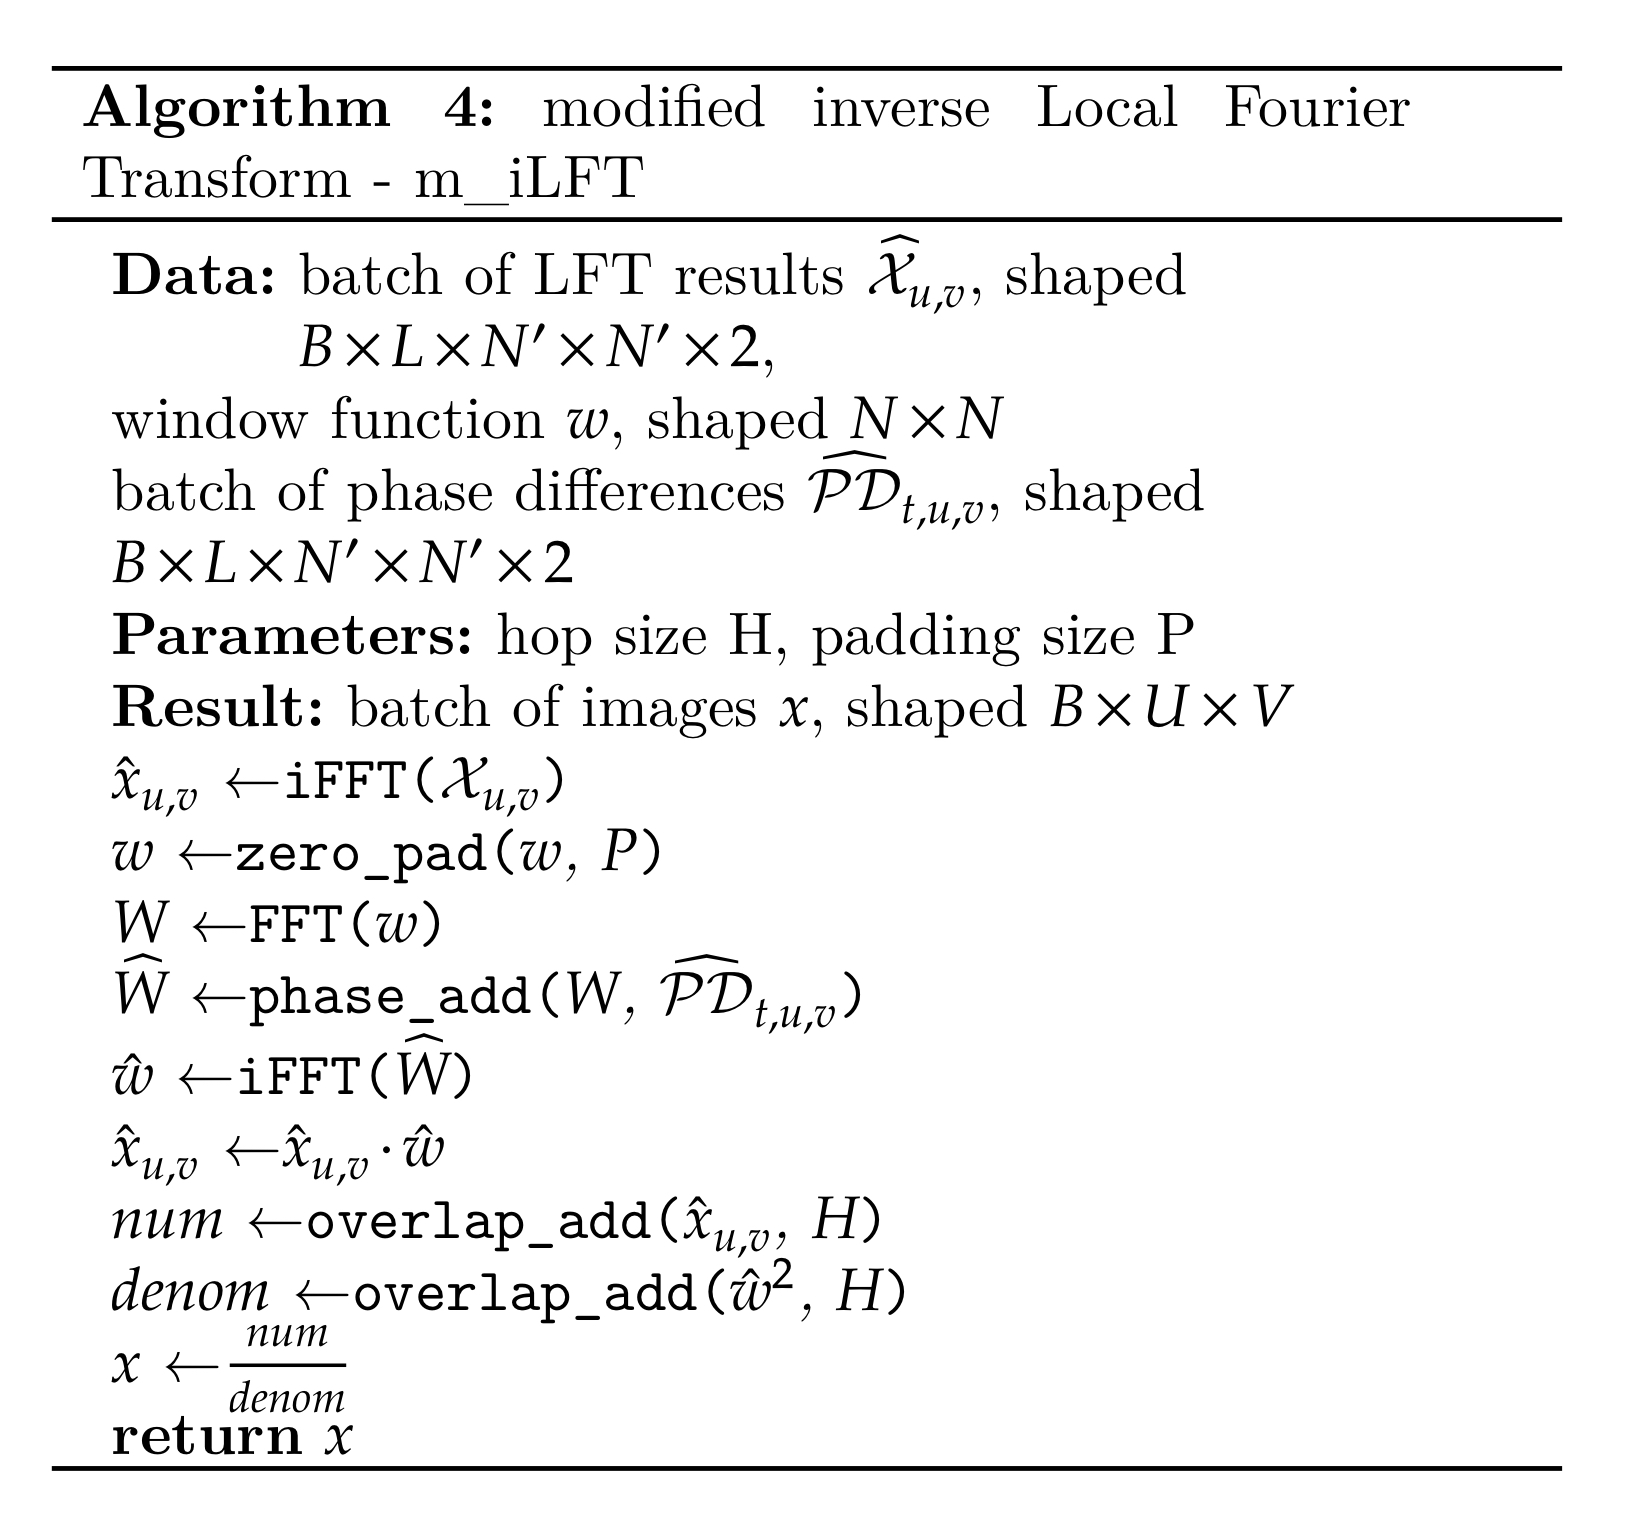

In [14]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(filename='prototyping/m_iLFT.jpg', width=600, height=450)

In [15]:
# this function handles overlap_add
def fold(T, res_y: int, res_x: int, y_stride: int, x_stride: int, cell_size: int, pad_size: int):
    fold_params = dict(kernel_size=(cell_size, cell_size), padding=(pad_size, pad_size), stride=(y_stride, x_stride))
    return nn.functional.fold(T, output_size=(res_y, res_x), **fold_params)

# locally define iFFT before transition to complex api
def custom_ifft(t_c):
    """2D FFT an input tensor

    Args:
        t_c -- tensor containing a complex 2D signal in its last three dimensions
    """
    t_c = torch.view_as_complex(t_c)
    result = torch.fft.ifftn(t_c, dim=(-2, -1), norm="forward" if normalizeFFT else "backward")
    return result.real


# these functions put together define the m_iLFT
def iLFT(stft2D_result, window, T, res_y: int, res_x: int, y_stride: int = 1, x_stride: int = 1, padding: int = 1,
         eps: float = 1e-8,is_inp_complex=True,move_window_according_T=True,channels=1):
    # dmsg("stft2D_result.shape")#torch.Size([BS, L_y*L_x*CS, N_p, N_p, 2])
    # dmsg("window.shape")#torch.Size([window_size*window_size])
    BS= stft2D_result.shape[0]
    cellSize = window.shape[0]

    ###this is the image padding, currently assumes x_stride == y_stride
    padSize = int(x_stride * ((cellSize - 1) // x_stride))

    cellSizeAdjust = cellSize + 2 * padding
    padSizeAdjust = int(x_stride * ((cellSizeAdjust - 1) // x_stride))

    ###the number of extracted cells along x and y axis
    ###this should be general enough to hold for different padSize
    num_windows_y = (res_y + 2 * padSizeAdjust - cellSizeAdjust) // y_stride + 1
    num_windows_x = (res_x + 2 * padSizeAdjust - cellSizeAdjust) // x_stride + 1
    num_windows_total = num_windows_y * num_windows_x

    if is_inp_complex:
        ifft_result = custom_ifft(stft2D_result)
    else:
        ifft_result = stft2D_result.clone()


    # dmsg("ifft_result.shape")#torch.Size([BS, L_y*L_x,CS, N_p, N_p])
    ifft_result = ifft_result.view((BS, num_windows_y, num_windows_x,channels, cellSizeAdjust, cellSizeAdjust))

    window_big = F.pad(window, (padding, padding, padding, padding), value=0.0)
    window_big = window_big.expand(BS, num_windows_total,channels, -1, -1)

    if move_window_according_T:
        window_big_Complex = custom_fft(window_big)
        window_big_Complex = getPhaseAdd(window_big_Complex, T.view_as(window_big_Complex))
        window_big = custom_ifft(window_big_Complex)

    window_big = window_big.view(BS, num_windows_y, num_windows_x,channels, window_big.shape[3], window_big.shape[4])

    ifft_result *= window_big

    ifft_result = ifft_result.reshape(BS, -1, ifft_result.shape[4] * ifft_result.shape[5]*channels).permute(0, 2, 1)
    test = fold(ifft_result, \
                res_y=res_y, res_x=res_x, y_stride=y_stride, x_stride=x_stride, cell_size=cellSizeAdjust,
                pad_size=padSizeAdjust)

    window_big = (window_big ** 2).reshape(BS, -1, window_big.shape[4] * window_big.shape[5]*channels).permute(0, 2, 1)
    windowTracker = fold(window_big, \
                         res_y=res_y, res_x=res_x, y_stride=y_stride, x_stride=x_stride, cell_size=cellSizeAdjust,
                         pad_size=padSizeAdjust)
                        

    windowTracker += eps
    weighted_result = test / windowTracker
    return weighted_result, windowTracker

# wrap the m_iLFT to accept WandB style config dicts as arguments
def compact_iLFT(LFT_result, window, T, config,is_inp_complex=True,move_window_according_T=True,channel=1):
    return iLFT(LFT_result, window, T, res_y=config.res_y_constrained, res_x=config.res_x_constrained, y_stride=config.stride,\
                    x_stride=config.stride, padding=config.window_padding_constrained,is_inp_complex=is_inp_complex,move_window_according_T=move_window_according_T,channels=channel)

In [16]:
# This class is just a config dictionary
class wandbdummy_m_iLFT():
    def __init__(self, stride, win_pad, H, W):
        self.stride = stride
        self.window_padding_constrained = win_pad
        self.res_y_constrained = H
        self.res_x_constrained = W
# Create hyperparameters
m_iLFT_config = wandbdummy_m_iLFT(stride=LFT_config.stride, win_pad=LFT_config.window_padding_constrained, H=H, W=W)
# Use m_iLFT not iLFT (move the window functions according to PD_curr, too)
move_window = True
# Reconstruct the next frame from the predicted LFT of the next frame using the modified iLFT
# This step completes the predict_next_frame algorithm
x_next, _ = compact_iLFT(LFT_next, window, PD_curr, m_iLFT_config, move_window_according_T=move_window, channel=C)
print('Next frame shape:', x_next.shape)

Next frame shape: torch.Size([12, 1, 65, 65])
